In [1]:
# set up spark
import sys
from os import listdir
from os.path import join,exists
pyspark_home = '/opt/apache-spark/python/lib'
zipfiles = [join(pyspark_home, f) for f in listdir(pyspark_home) if f.endswith('.zip')]
sys.path += zipfiles
from pyspark import *
from pyspark.sql import *
from pyspark.sql.functions import *
spark = SparkSession.builder.getOrCreate()

import matplotlib.pyplot as plt
import numpy as np
%pylab inline

path = '/home/gaoxiang/MEGA/tables'

Populating the interactive namespace from numpy and matplotlib


/usr/lib/python3.5/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['hypot', 'broadcast', 'tan', 'rank', 'sqrt', 'tanh', 'log1p', 'log', 'cbrt', 'size', 'array', 'rint', 'log10', 'sin', 'sinh', 'sum', 'randn', 'expm1', 'isnan', 'exp', 'rand', 'floor', 'log2', 'mean', 'cosh', 'repeat', 'split', 'cos', 'trunc', 'ceil']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


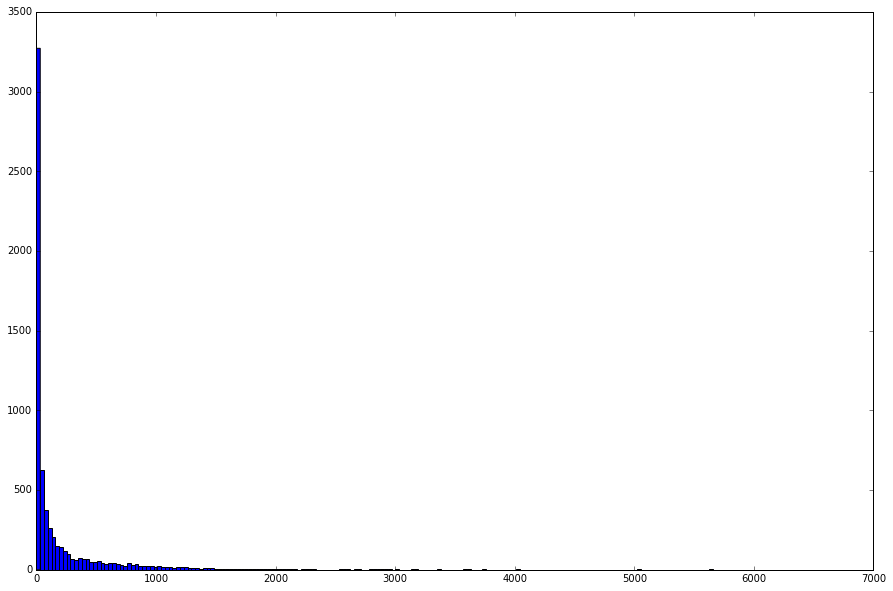

+----+-----+
|rank|count|
+----+-----+
|   0|  859|
|   1|  378|
|   2|  236|
|   3|  187|
|   4|  141|
|   5|  125|
|   6|  131|
|   7|  100|
|   8|   78|
|   9|   76|
|  10|   77|
|  11|   65|
|  12|   77|
|  13|   58|
|  14|   52|
|  15|   43|
|  16|   44|
|  17|   59|
|  18|   46|
|  19|   49|
+----+-----+
only showing top 20 rows



In [2]:
distances = spark.read.parquet(path+'/distances')
ranks = distances.select('rank')
local = ranks.collect()
rank = [row['rank'] for row in local]
fig,ax = plt.subplots()
plt.hist(rank,200)
fig.set_size_inches(15, 10)
plt.show()
ranks.groupBy('rank').count().sort('rank').show()

+---------+--------------------+----+---------+--------------------+--------------------+
|      mid|              smiles|rank|rankrange|              expvec|               thvec|
+---------+--------------------+----+---------+--------------------+--------------------+
|  C103059|  CC(C)(O)CCc1ccccc1|   0|        0|[0.06436762924444...|[0.52070387525748...|
|  C592881|           C=CCSCC=C|   1|        1|[0.03134251208038...|[0.06107973521844...|
|  C712505|O=C(c1ccccc1)C1CC...|   2|        2|[0.24325696576091...|[0.98956131088568...|
|C36377590|  CCOc1ccc(CCN)cc1OC|   6|        3|[0.01708340613943...|[0.22519244398579...|
|  C135773|  COc1ccc(OC)c(OC)c1|   7|        4|[0.03067097317510...|[0.28400606714005...|
| C1009116| CCCC(=O)c1ccc(O)cc1|  13|        5|[0.01631046310512...|[0.13018731331211...|
| C3683123|C=C(C)C(=O)OCCc1c...|  22|        6|[0.01967202148253...|[0.63178007116193...|
|   C71410|              CCCCCO|  40|        7|[0.11580837089350...|[0.03034851518717...|
|  C926567

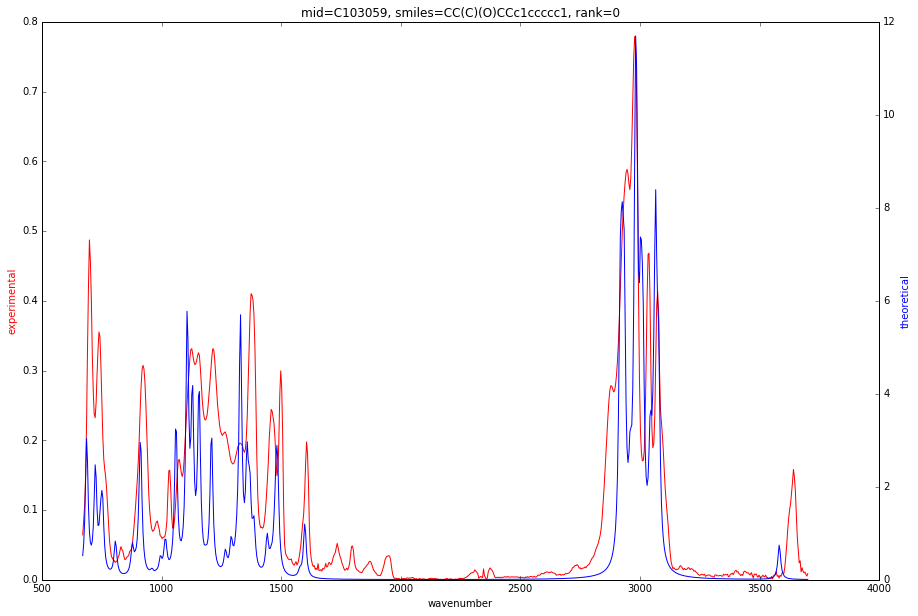

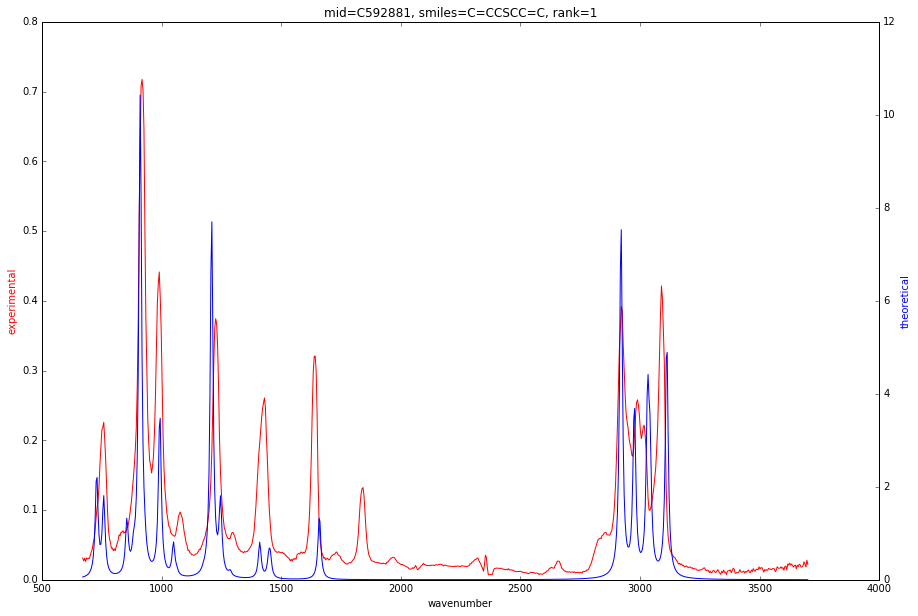

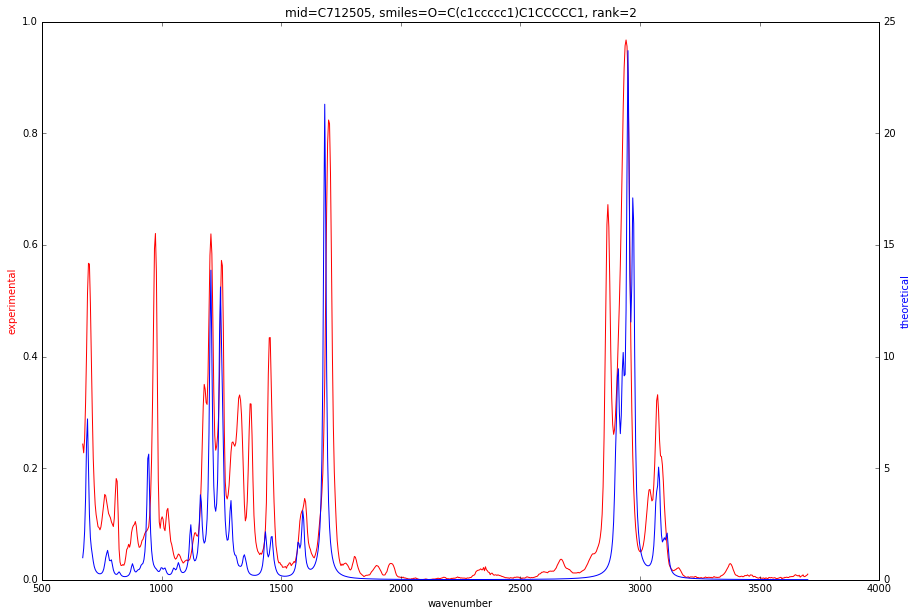

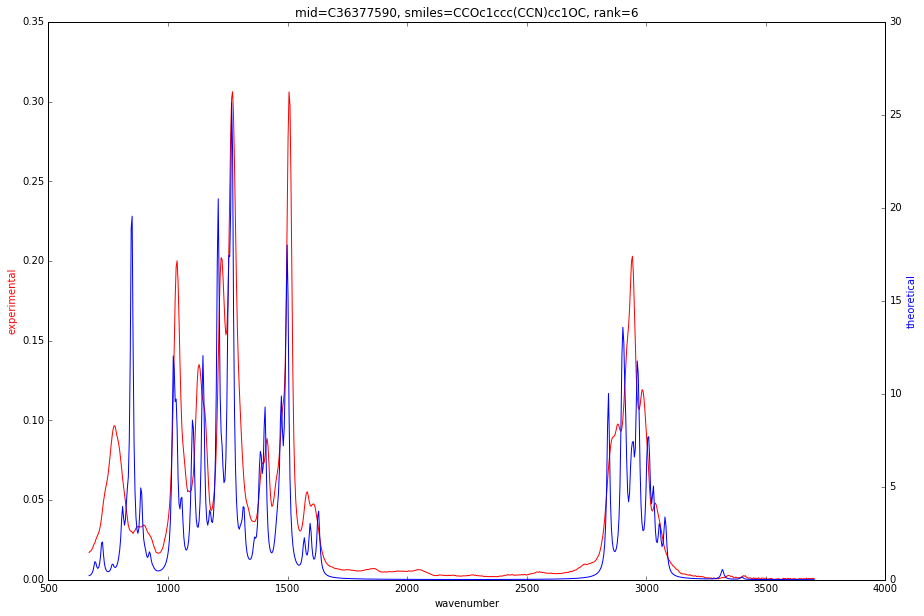

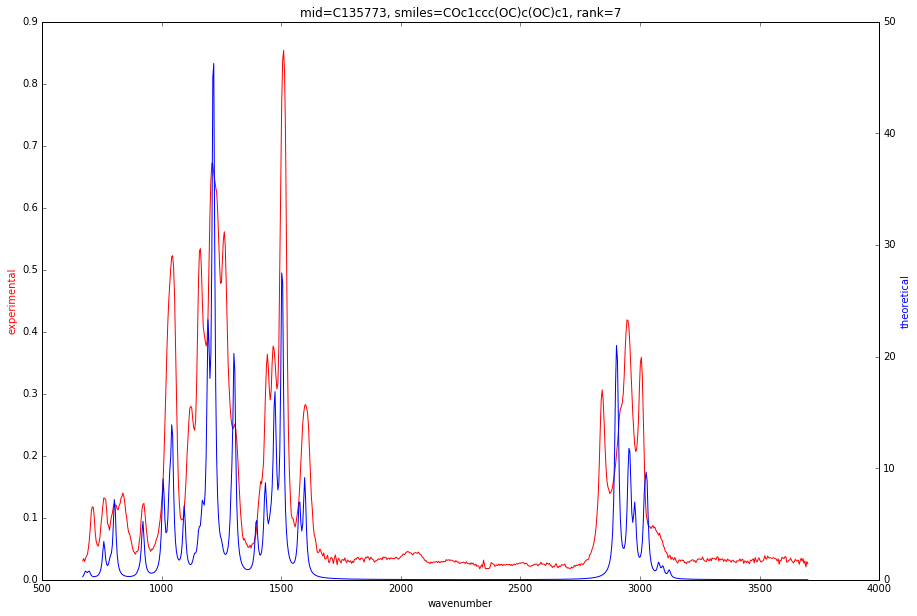

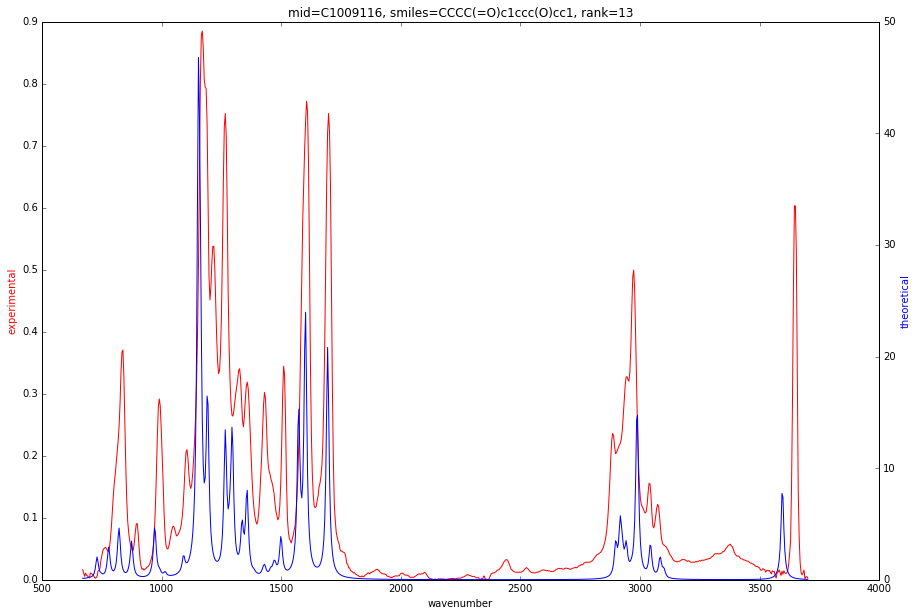

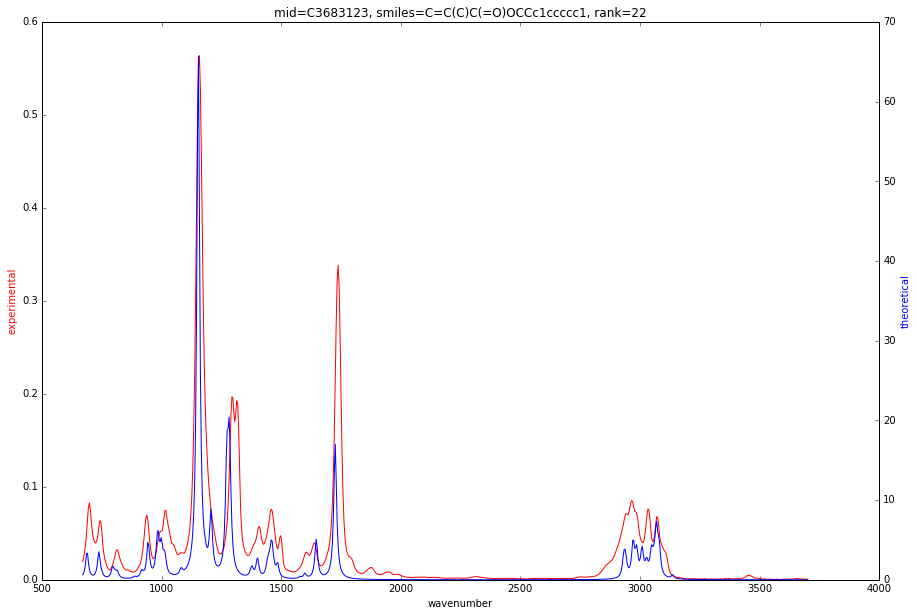

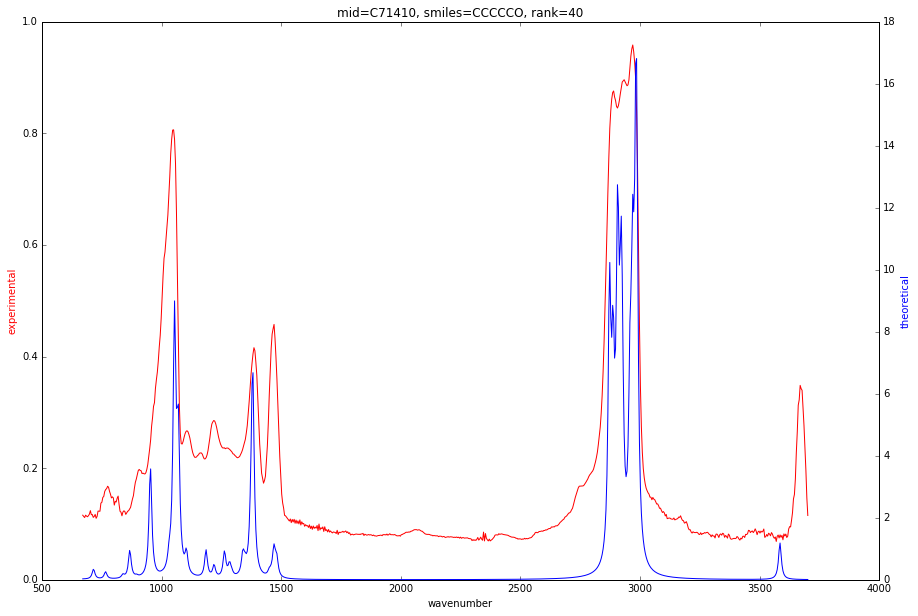

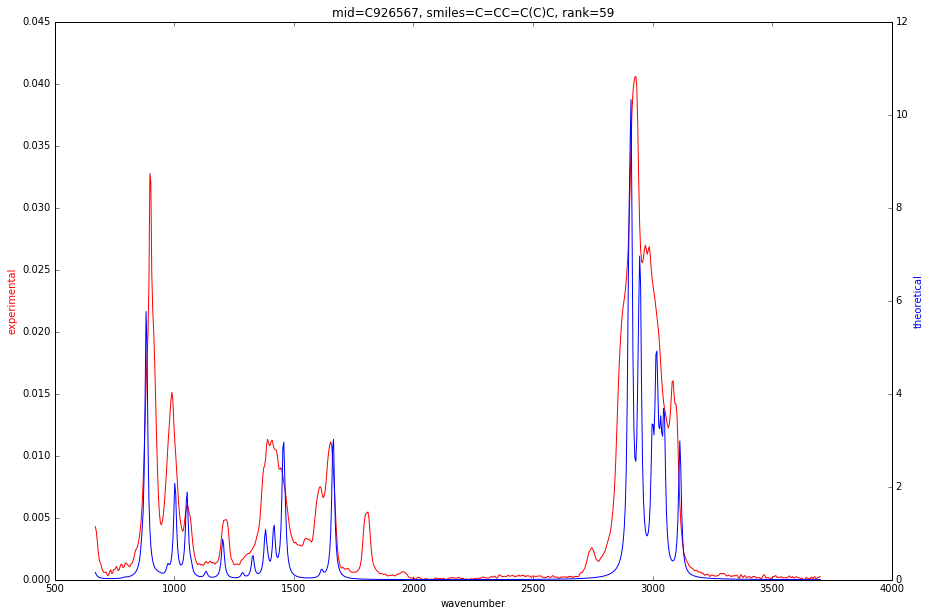

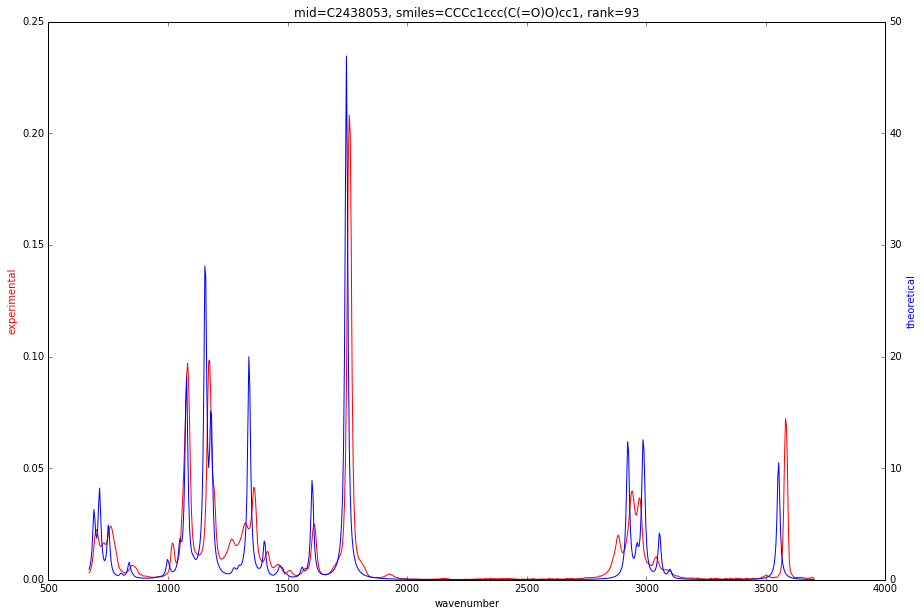

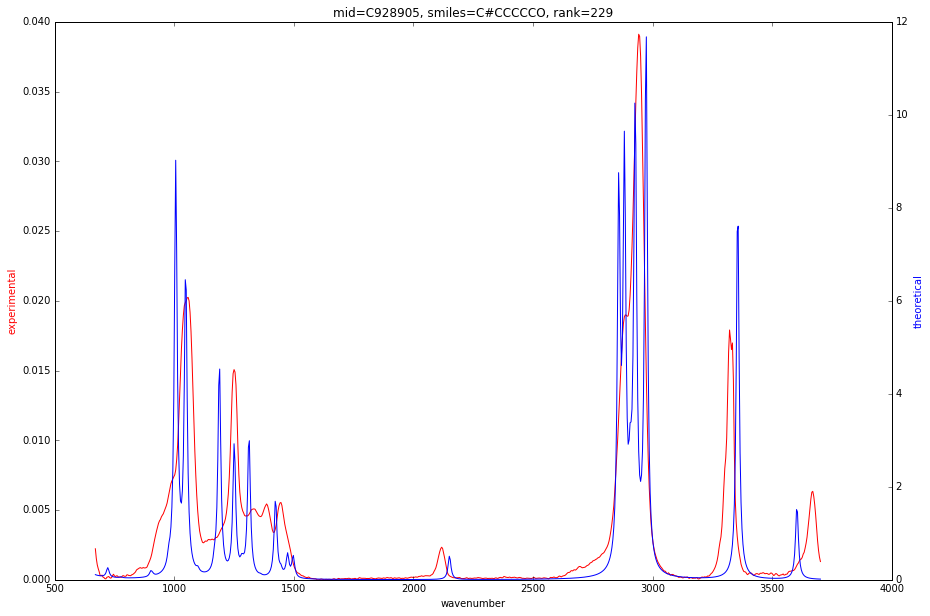

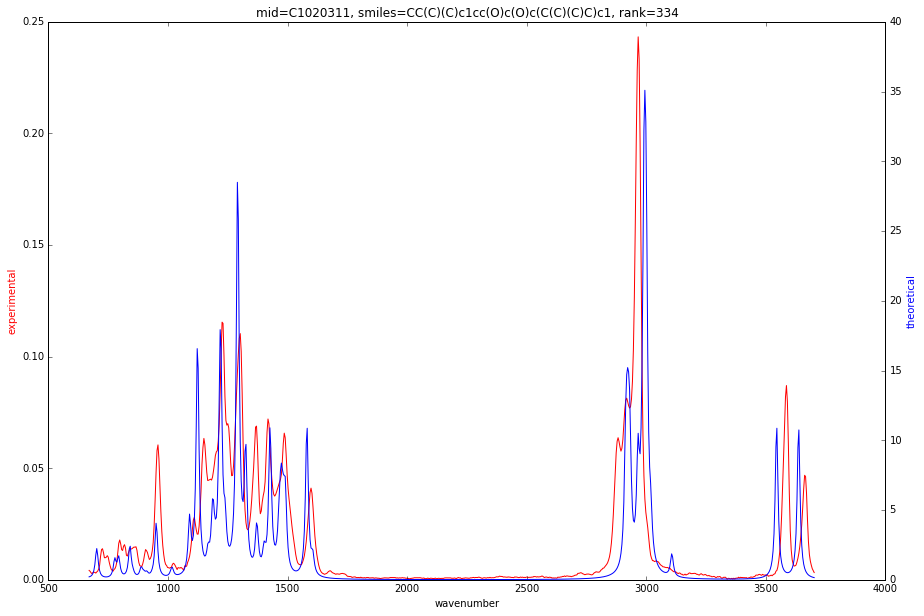

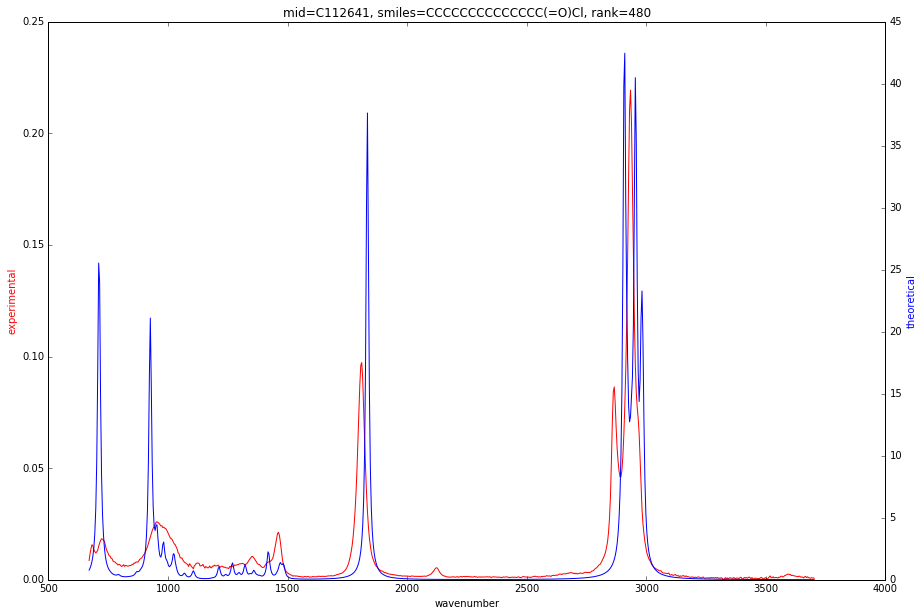

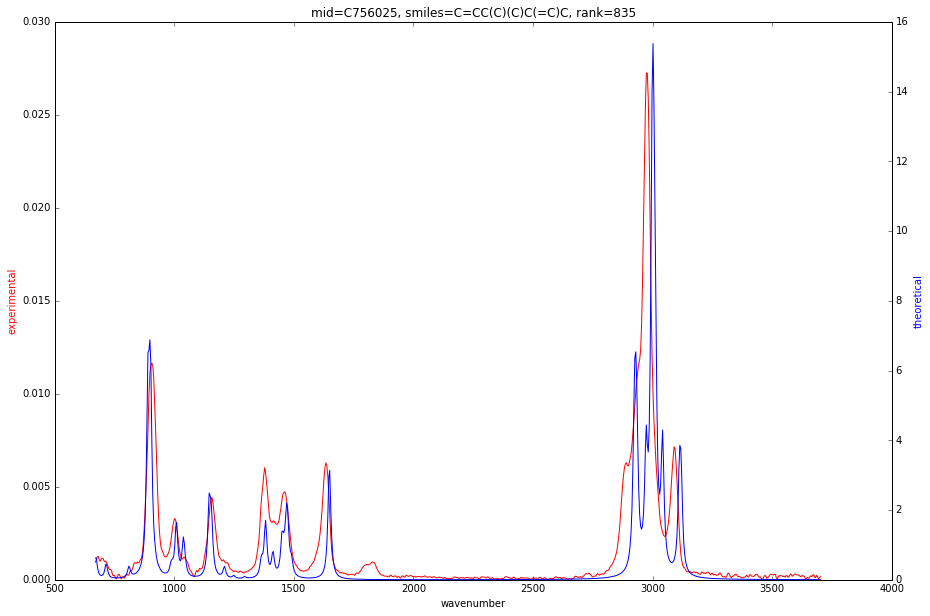

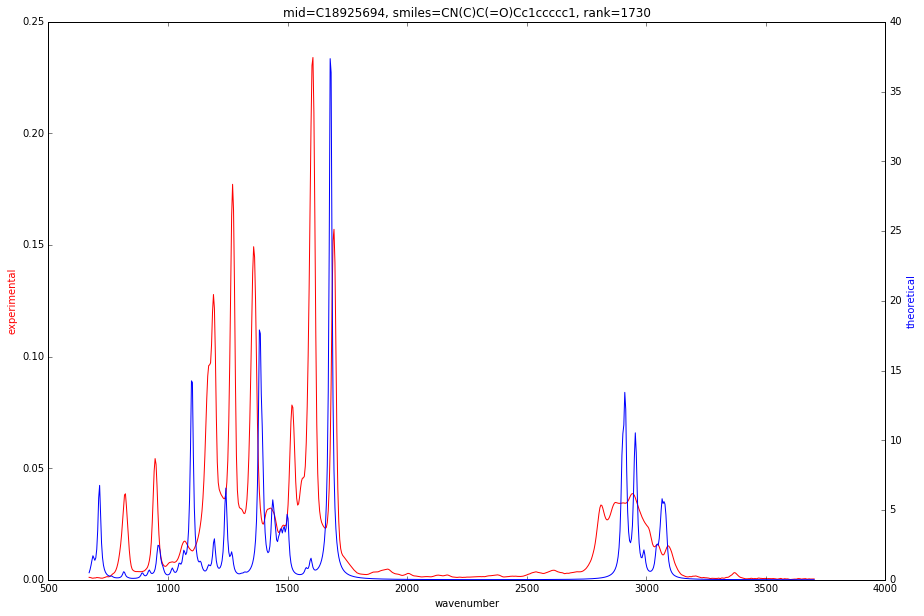

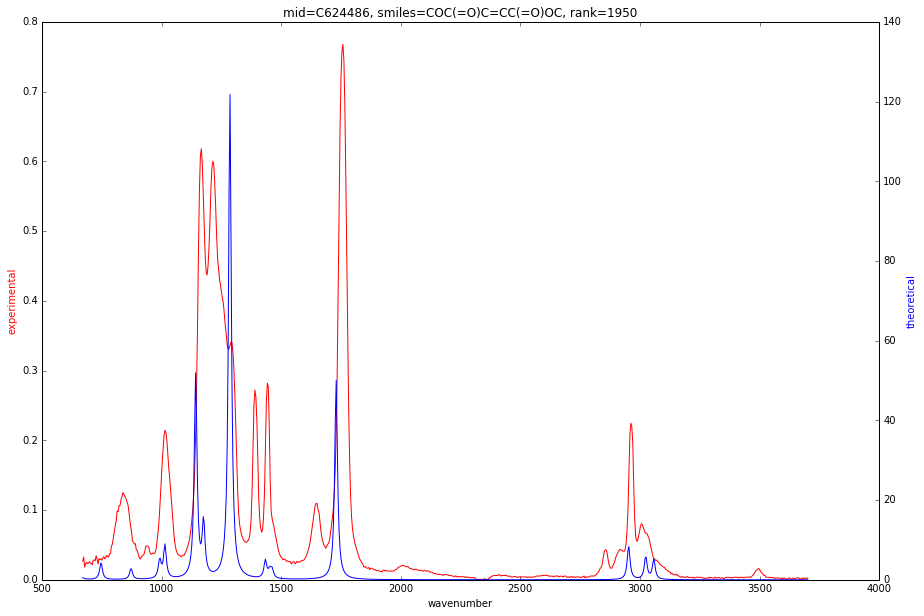

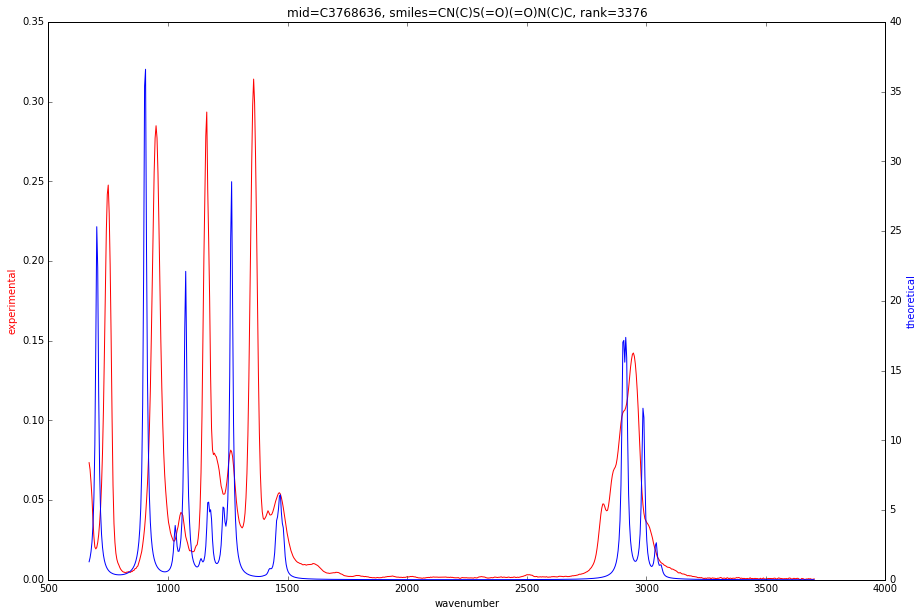

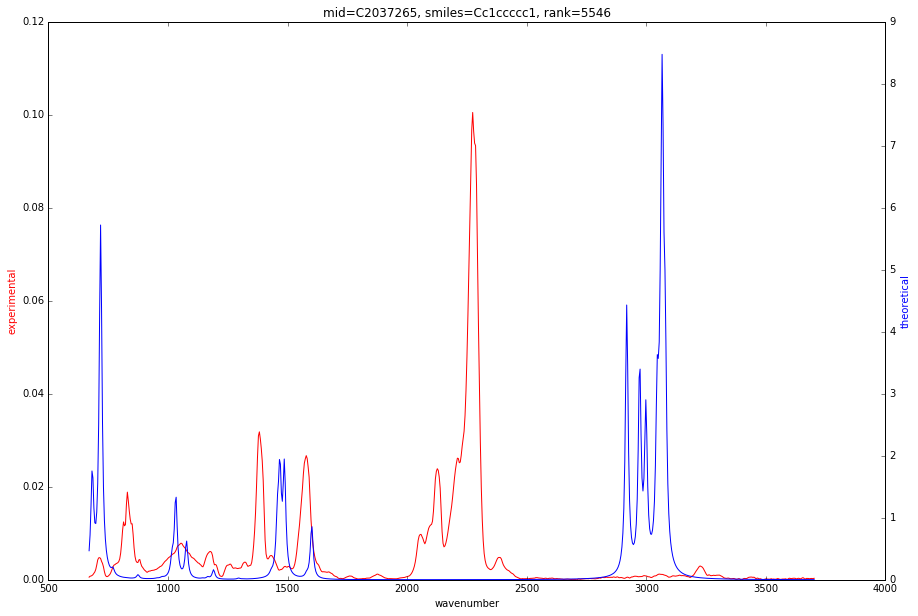

In [5]:
# get good and bad examples
thexpvec = spark.read.parquet(path+'/thexpvec')
disvec = thexpvec.join(distances.withColumnRenamed('exp_smiles','smiles'),'smiles') \
                 .select('mid','smiles','rank','expvec','thvec') \
                 .dropDuplicates(['smiles'])
selected = disvec.select('mid','smiles','rank',expr('int(2*log(1+rank))').alias('rankrange'),'expvec','thvec')\
                 .dropDuplicates(['rankrange']).sort('rankrange')
selected.show()


# plot
local = selected.collect()
xs = range(670,3706,4)
for row in local:
    mid = row['mid']
    smiles = row['smiles']
    rank = row['rank']
    expvec = row['expvec']
    thvec = row['thvec']
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    ax1.set_xlabel('wavenumber')
    ax1.set_ylabel('experimental', color='r')
    ax2.set_ylabel('theoretical', color='b')
    plt.title("mid={}, smiles={}, rank={}".format(mid,smiles,rank))
    ax1.plot(xs,expvec,'r',label='experimental')
    ax2.plot(xs,thvec,'b',label='theoretical')
    fig.set_size_inches(15, 10)
    plt.show()